# Exercise V: Regularization

```{margin}
More information about the dataset can be found [here](https://rdrr.io/cran/ISLR/man/Hitters.html).
```

This exercise is an adaptation of lab 2 from the [ISLR](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), in which the salary of baseball players is predicted on the basis of various statistics associated with performance in the previous year.

## Set up

In [1]:
import pandas as pd

URL = "https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Hitters.csv"
data = pd.read_csv(URL, index_col=0)

## General Inspection and Preprocessing

In [2]:
data

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-Willie McGee,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
-Willie Randolph,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
-Wayne Tolleson,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
-Willie Upshaw,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


Well, it looks like a dataset. 

Let's probe a little deeper:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322 entries, -Andy Allanson to -Willie Wilson
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    obje

In [4]:
from myst_nb import glue

n_numerical_hitters = len(data.select_dtypes(int).columns)
n_features_hitters = len(data.columns) - 1

glue("n_numerical_hitters", n_numerical_hitters, display=False)
glue("n_features_hitters", n_features_hitters, display=False)

Calling `info()` reveals that most ({glue:text}`n_numerical_hitters`/{glue:text}`n_features_hitters`) columns contain integers, except for `Salary` which is a `float` and `League`, `NewLeague`, and `Division` which are `object` (categorical). Even more importantly, it shows that `Salary` contains missing observations. Because `Salary` is our target variable, we don't really have any use for these observations and would be better off simply dropping them from our dataset:

In [5]:
data.dropna(subset=["Salary"], inplace=True)

Done. 

Next, we might give `describe()` a quick look:

In [6]:
pd.set_option('float_format', '{:.4g}'.format)
data.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
count,263,263,263,263,263,263,263,263,263,263,263,263,263,263,263,263,263
mean,403.6,107.8,11.62,54.75,51.49,41.11,7.312,2658,722.2,69.24,361.2,330.4,260.3,290.7,118.8,8.593,535.9
std,147.3,45.13,8.757,25.54,25.88,21.72,4.794,2287,648.2,82.2,331.2,323.4,264.1,279.9,145.1,6.607,451.1
min,19,1,0,0,0,0,1,19,4,0,2,3,1,0,0,0,67.5
25%,282.5,71.5,5,33.5,30,23,4,842.5,212,15,105.5,95,71,113.5,8,3,190
50%,413,103,9,52,47,37,6,1931,516,40,250,230,174,224,45,7,425
75%,526,141.5,18,73,71,57,10,3890,1054,92.5,497.5,424.5,328.5,322.5,192,13,750
max,687,238,40,130,121,105,24,1.405e+04,4256,548,2165,1659,1566,1377,492,32,2460


### Scaling

I seems like there's fairly large variabiliy in scale between the different features, and in any case regularization requires some form of standardization. 

First, let's differntiate the features matrix (`X`) from the target vector (`y`):

In [7]:
target_name = "Salary"

X = data.drop(columns=[target_name])
y = data[target_name].copy()

Only numeric columns should be standardized, so let's also be sure to distinguish those from the categoricals:

In [8]:
numeric_features = X.select_dtypes([int, float])

And we're all set:

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X.loc[:, numeric_features.columns] = scaler.fit_transform(
    X.loc[:, numeric_features.columns])

In [10]:
X

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,NewLeague
-Alan Ashby,-0.6029,-0.5957,-0.5286,-1.206,-0.5221,-0.09753,1.398,0.3468,0.1744,-0.00292,-0.1217,0.259,0.4353,N,W,1.221,-0.5232,0.2134,N
-Alvin Davis,0.5125,0.4923,0.73,0.4415,0.7941,1.609,-0.9012,-0.4529,-0.4099,-0.07605,-0.4151,-0.1996,0.01037,A,W,2.109,-0.2539,0.82,A
-Andre Dawson,0.6282,0.7365,0.9588,0.4023,1.026,-0.1898,0.7709,1.302,1.318,1.899,1.412,1.573,0.3557,N,E,-0.3247,-0.7442,-0.8482,N
-Andres Galarraga,-0.5621,-0.4625,-0.1853,-0.6177,-0.3672,-0.5127,-1.11,-0.9909,-0.9602,-0.6977,-0.9475,-0.8812,-0.8623,N,E,1.841,-0.5439,-0.6966,N
-Alfredo Griffin,1.295,1.358,-0.8718,0.7553,-0.01884,-0.2821,0.7709,0.767,0.635,-0.6124,0.4228,0.01729,-0.2514,A,W,-0.03118,2.087,2.488,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-Willie McGee,0.635,0.4257,-0.5286,0.4023,-0.135,-0.1898,-0.4832,0.01992,0.1295,-0.4539,0.05378,-0.06016,-0.4639,N,E,0.1227,-0.758,-0.8482,N
-Willie Randolph,0.601,0.6255,-0.7574,0.8338,-0.05755,2.44,0.9799,1.25,1.219,-0.3686,1.621,0.3736,2.332,A,E,0.07977,1.811,1.73,A
-Wayne Tolleson,0.4853,0.4034,-0.9862,0.2454,-0.3285,0.5022,-0.2742,-0.4196,-0.447,-0.7586,-0.4363,-0.7356,-0.4336,A,W,-0.9081,-0.03978,-0.2416,A
-Willie Upshaw,1.152,0.8031,-0.2997,1.187,0.3295,1.702,0.1438,0.2368,0.2084,0.3384,0.3291,0.2776,0.2722,A,E,3.662,0.08452,0.5167,A


In [11]:
X.describe()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
count,263,263,263,263,263,263,263,263,263,263,263,263,263,263,263,263
mean,1.013e-17,5.741e-17,3.377e-17,-5.066e-17,1.216e-16,1.689e-18,-5.403e-17,6.079e-17,6.754e-17,5.403e-17,3.377e-17,4.053e-17,1.081e-16,7.43e-17,0,1.047e-16
std,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002,1.002
min,-2.616,-2.372,-1.329,-2.148,-1.993,-1.897,-1.319,-1.156,-1.11,-0.844,-1.087,-1.014,-0.9837,-1.04,-0.8201,-1.303
25%,-0.8239,-0.8066,-0.7574,-0.8334,-0.8317,-0.8356,-0.6922,-0.7953,-0.7886,-0.6611,-0.7736,-0.7294,-0.7181,-0.6343,-0.7649,-0.8482
50%,0.06364,-0.1072,-0.2997,-0.1077,-0.1737,-0.1898,-0.2742,-0.3183,-0.3187,-0.3564,-0.3365,-0.3111,-0.3273,-0.2388,-0.5094,-0.2416
75%,0.8322,0.7476,0.73,0.7161,0.7554,0.7329,0.5619,0.5402,0.5129,0.2835,0.4123,0.2915,0.2589,0.1138,0.5058,0.6683
max,1.927,2.89,3.247,2.952,2.691,2.947,3.488,4.993,5.462,5.836,5.457,4.116,4.954,3.888,2.578,3.55


### Pairwise Scatter-matrix

In [12]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore", category=matplotlib.cbook.MatplotlibDeprecationWarning)

In [13]:
_ = pd.plotting.scatter_matrix(data, figsize=(15, 15))

### Dummy Encoding

To view the different values each categorical variable holds:

In [14]:
for feature in X.select_dtypes(object):
    print(feature.ljust(10), X[feature].unique())

League     ['N' 'A']
Division   ['W' 'E']
NewLeague  ['N' 'A']


And to "dummy encode" it is as simple as:

In [15]:
X = pd.get_dummies(X, drop_first=True)

In [29]:
X.sample(20).select_dtypes(include=["uint8"]).style.background_gradient()

,League_N,Division_W,NewLeague_N
-Pat Tabler,0,0,0
-Tony Phillips,0,1,0
-Mike Kingery,0,1,0
-Craig Reynolds,1,1,1
-Vance Law,1,0,1
-Kal Daniels,1,1,1
-Mike Easler,0,0,1
-Darrell Porter,0,1,0
-Carmelo Martinez,1,1,1
-Herm Winningham,1,0,1


## Model Creation

In the previous linear regression exercise we used `sklearn`'s [`LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) class along with the [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function to model the relationship between the features and the target variable and evaluate it's performance in predicting the target variable for an out-of-sample collection of observations. In this exercise, we will use [`LassoCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV) and [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html) to introduce the $\ell_1$ and $\ell_2$ penalties as part of our fitting process and regularize the coefficients of our predictors. In addition, [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics)) will also be taken care of automatically.

For the sake of uniformity we'll use the same list of regularization parameter values:

In [19]:
import numpy as np

alphas = np.linspace(0.01, 100, 200)

````{panels}
Lasso ($\ell_1$)
^^^
```
from sklearn.linear_model import LassoCV

lasso_model = LassoCV(alphas=alphas, max_iter=10000)
_ = lasso_model.fit(X, y)
```
---

Ridge ($\ell_2$)
^^^
```
from sklearn.linear_model import RidgeCV

ridge_model = RidgeCV(alphas=alphas, store_cv_values=True)
_ = ridge_model.fit(X, y)
```
````

In [20]:
from sklearn.linear_model import LassoCV

lasso_model = LassoCV(alphas=alphas, max_iter=10000, random_state=0)
_ = lasso_model.fit(X, y)

In [21]:
from sklearn.linear_model import RidgeCV

ridge_model = RidgeCV(alphas=alphas, store_cv_values=True)
_ = ridge_model.fit(X, y)

```{note}
By default, `LassoCV` will use 5-fold cross-validation with $R^2$ as the scoring method and `RidgeCV` will use Generalized Cross-Validation, which is a form of efficient Leave-One-Out cross-validation, with negative mean squared error. 

To change the splitting strategy, set the `cv` keyword argument to the number of folds you'd like to use, to specify scoring and other search parameters see the [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV) class.
```

## Model Application

To calculate the predicted salary of each player using the model:

````{panels}
Lasso ($\ell_1$)
^^^
```
lasso_predictions = lasso_model.predict(X)
```
---

Ridge ($\ell_2$)
^^^
```
ridge_predictions = ridge_model.predict(X)
```
````

In [22]:
lasso_predictions = lasso_model.predict(X)
ridge_predictions = ridge_model.predict(X)

## Model Evaluation

In [23]:
import matplotlib.pyplot as plt


def plot_predictions(y: pd.Series, predictions: pd.Series, ax: plt.Axes):
    ax.scatter(y, predictions, color="black")
    ax.plot(y, y, color="red")
    ax.set_xlabel("Real Values")
    ax.set_ylabel("Predicted Values")


fig, ax = plt.subplots(ncols=2, figsize=(12, 5))
plot_predictions(y, lasso_predictions, ax[0])
ax[0].set_title(r"Lasso ($\ell_1$)")
plot_predictions(y, ridge_predictions, ax[1])
_ = ax[1].set_title(r"Lasso ($\ell_2$)")

## Alpha

In [24]:
lasso_alpha = lasso_model.alpha_
glue("lasso_alpha", lasso_alpha, display=False)

In [25]:
ridge_alpha = ridge_model.alpha_
glue("ridge_alpha", ridge_alpha, display=False)

````{panels}
Lasso ($\ell_1$)
^^^
```
lasso_model.alpha_
```
{glue:}`lasso_alpha`
---

Ridge ($\ell_2$)
^^^
```
ridge_model.alpha_
```
{glue:}`ridge_alpha`
````

### Coefficients

In [26]:
coefficients_dict = {"Lasso": lasso_model.coef_, "Ridge": ridge_model.coef_}
coefficients = pd.DataFrame(coefficients_dict, index=X.columns)
coefficients.T

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
Lasso,-237.2,261.6,0,-0,0,104.8,-46.64,-0,0,44.29,224.5,123.9,-144.8,76.81,26.48,-13.56,27.04,-114.1,0
Ridge,-216.4,230.7,0.9447,0.7865,6.002,106.3,-51.34,-94.18,119.4,58.18,199.9,114.5,-144.5,77.68,39.18,-24.86,50.73,-118.6,-18.02


In [27]:
from sklearn.linear_model import Lasso, Ridge


coef_fig, coef_ax = plt.subplots(ncols=2, figsize=(14, 6))

#########
# Lasso #
#########

simple_lasso = Lasso(max_iter=10_000)
lasso_coefficient_values = []
lasso_alphas = lasso_model.alphas_[::-1]

for alpha in lasso_alphas:
    simple_lasso.set_params(alpha=alpha)
    simple_lasso.fit(X, y)
    lasso_coefficient_values.append(simple_lasso.coef_)

# Coefficient values by alpha
coef_ax[0].semilogx(lasso_alphas, lasso_coefficient_values, linestyle="dashed", alpha=0.5)

# Chosen alpha
coef_ax[0].axvline(lasso_model.alpha_,
                  linestyle='--',
                  color="black",
                  label=r"Chosen $\alpha$")
coef_ax[0].legend()
coef_ax[0].set_xlabel(r'$\alpha$')
coef_ax[0].set_ylabel("Coefficient Values")
coef_ax[0].set_title(r"Lasso: Coefficient Values by $\alpha$")

#########
# Ridge #
#########

simple_ridge = Ridge()
ridge_coefficient_values = []
ridge_alphas = ridge_model.alphas[::-1]

for alpha in ridge_alphas:
    simple_ridge.set_params(alpha=alpha)
    simple_ridge.fit(X, y)
    ridge_coefficient_values.append(simple_ridge.coef_)


# Coefficient values by alpha
coef_ax[1].semilogx(ridge_alphas,
                   ridge_coefficient_values,
                   linestyle="dashed",
                   alpha=0.5)
# Chosen alpha
coef_ax[1].axvline(ridge_model.alpha_,
                  linestyle='--',
                  color="black",
                  label=r"Chosen $\alpha$")
coef_ax[1].legend(X.columns, loc="upper left", bbox_to_anchor=(1.05, 0.95))
coef_ax[1].set_xlabel(r'$\alpha$')
coef_ax[1].set_ylabel("Coefficient Values")
_ = coef_ax[1].set_title(r"Ridge: Coefficient Values by $\alpha$")

### Mean Squared Error (MSE)

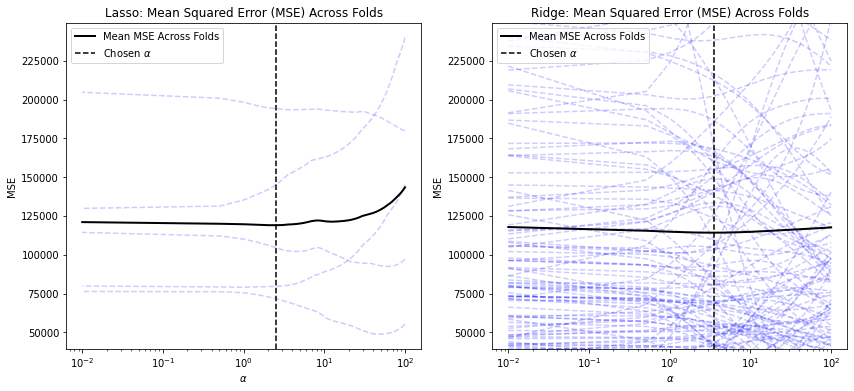

In [24]:
mse_fig, mse_ax = plt.subplots(ncols=2, figsize=(14, 6))

#########
# Lasso #
#########

lasso_alphas = lasso_model.alphas_
lasso_mse = lasso_model.mse_path_

# Cross-validation MSEs
mse_ax[0].semilogx(lasso_alphas,
                   lasso_mse,
                   linestyle="dashed",
                   color="blue",
                   alpha=0.2)

# Mean MSE
mse_ax[0].plot(lasso_alphas,
               lasso_mse.mean(axis=-1),
               color="black",
               label="Mean MSE Across Folds",
               linewidth=2)
# Chosen alpha
mse_ax[0].axvline(lasso_model.alpha_,
                  linestyle='--',
                  color="black",
                  label=r"Chosen $\alpha$")
mse_ax[0].legend()
mse_ax[0].set_xlabel(r'$\alpha$')
mse_ax[0].set_ylabel("MSE")
mse_ax[0].set_title("Lasso: Mean Squared Error (MSE) Across Folds")

#########
# Ridge #
#########

ridge_alphas = ridge_model.alphas
ridge_mse = ridge_model.cv_values_.T

# Cross-validation MSEs
mse_ax[1].semilogx(ridge_alphas,
                   ridge_mse,
                   linestyle="dashed",
                   color="blue",
                   alpha=0.2)
# Mean MSE
mse_ax[1].plot(ridge_alphas,
               ridge_mse.mean(axis=-1),
               color="black",
               label="Mean MSE Across Folds",
               linewidth=2)
# Chosen alpha
mse_ax[1].axvline(ridge_model.alpha_,
                  linestyle='--',
                  color="black",
                  label=r"Chosen $\alpha$")
mse_ax[1].legend()
mse_ax[1].set_xlabel(r'$\alpha$')
mse_ax[1].set_ylabel("MSE")
mse_ax[1].ticklabel_format(style="plain", axis="y")
mse_ax[1].set_ylim(mse_ax[0].get_ylim())
_ = mse_ax[1].set_title("Ridge: Mean Squared Error (MSE) Across Folds")

### $R^2$

To calculate in-sample $R^2$ score for each model:

In [25]:
lasso_score = lasso_model.score(X, y)
glue("lasso_score", lasso_score, display=False)

In [26]:
ridge_score = ridge_model.score(X, y)
glue("ridge_score", ridge_score, display=False)

````{panels}
Lasso ($\ell_1$)
^^^
```
lasso_model.score(X, y)
```
{glue:}`lasso_score`
---

Ridge ($\ell_2$)
^^^
```
ridge_model.score(X, y)
```
{glue:}`ridge_score`
````

Note that calculating in-sample $R^2$ scores will result in underestimating prediction error.

```{note}
For a more generalized solution for parameter tuning, see `sklearn`'s [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV).
```